In [3]:
# cargamos todas las librerias necesarias
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# Parte 1: Carga y Exploración Inicial de Datos

## 1. Carga del Dataset:
* Cargar el dataset desde Kaggle

In [4]:
# cargamos el dataset desde train.csv
ruta = '../data/train.csv'
df = pd.read_csv(filepath_or_buffer=ruta, sep=',')
df.shape

(614, 13)

## 2. Exploración Inicial:
* Revisar la estructura del dataset.
* Describir las variables y su distribución.
* Identificar y documentar valores faltantes y outliers.

In [4]:
df.info() # mostramos informacio sobre el dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


* VAriables y su funcion
    * Loan_ID: Identificador único del préstamo. Este código permite distinguir cada solicitud de préstamo en el dataset.
    * Gender: Género del solicitante del préstamo. Puede ser "Male" (masculino) o "Female" (femenino).
    * Married: Estado civil del solicitante. Indica si el solicitante está casado ("Yes") o no ("No").
    * Dependents: Número de dependientes que tiene el solicitante. Este valor puede ser un número entero, donde "0" indica que no tiene dependientes.
    * Education: Nivel educativo del solicitante. Puede ser "Graduate" (graduado) o "Not Graduate" (no graduado).
    * Self_Employed: Indica si el solicitante es trabajador autónomo ("Yes") o empleado en una empresa ("No").
    * ApplicantIncome: Ingreso mensual del solicitante, expresado en la moneda local. Este valor es importante para evaluar la capacidad de pago.
    * CoapplicantIncome: Ingreso mensual del co-solicitante (si aplica), también expresado en la moneda local.
    * LoanAmount: Monto total del préstamo solicitado, expresado en la moneda local. Este campo puede estar vacío en algunos registros.
    * Loan_Amount_Term: Duración del préstamo en meses. Comúnmente, este valor es de 360 meses para préstamos a largo plazo.
    * Credit_History: Historial crediticio del solicitante. Un valor de "1" indica que el solicitante tiene un buen historial crediticio, mientras que "0" indica lo contrario.
    * Property_Area:Tipo de área donde se encuentra la propiedad relacionada con el préstamo. Puede ser "Urban" (urbano), "Rural" (rural) o "Semiurban" (semiurbano).
    * Loan_Status: Estado del préstamo solicitado, indicando si fue aprobado ("Y") o rechazado ("N").

In [5]:
df.isnull().sum() # verificamos la existencia de valores nulos

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [6]:
# creamos una lista de columnas numericas y categoricas
numerical_columns = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']
categorical_columns = ['Gender', 'Married', 'Dependents', 'Self_Employed', 'Education', 'Property_Area', 'Loan_Status']

In [7]:
# impotamos valores faltantes en columnas numéricas con la mediana
for col in numerical_columns:
    median_value = df[col].median()  # Calcular la mediana
    df[col].fillna(median_value, inplace=True)  # Rellenar valores faltantes con la mediana

# imputamos valores faltantes en columnas categóricas con la moda
for col in categorical_columns:
    mode_value = df[col].mode()[0]  # Calcular la moda
    df[col].fillna(mode_value, inplace=True)  # Rellenar valores faltantes con la moda

# verificamos si hay valores faltantes
print("Valores faltantes después de la imputación:")
print(df.isnull().sum())

Valores faltantes después de la imputación:
Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64


/tmp/ipykernel_103893/3971046525.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median_value, inplace=True)  # Rellenar valores faltantes con la mediana
/tmp/ipykernel_103893/3971046525.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 

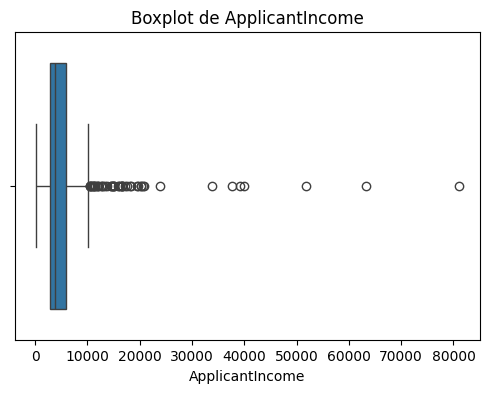

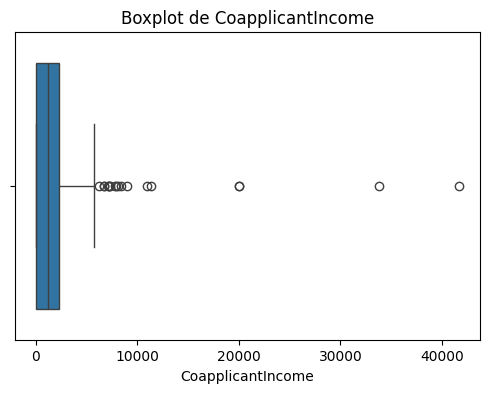

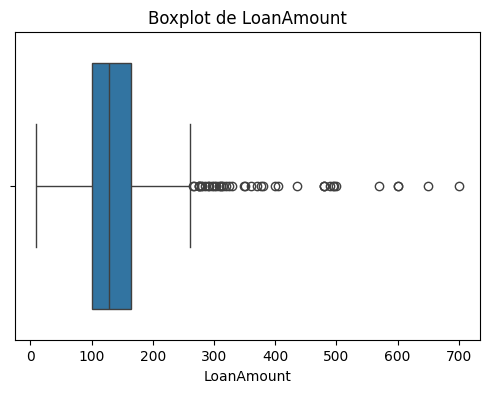

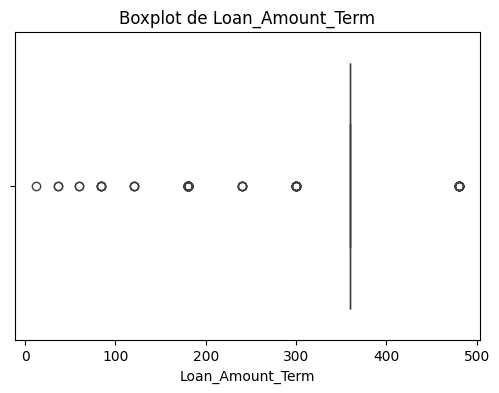

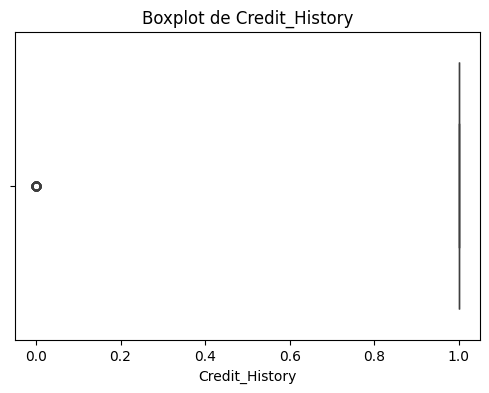

In [13]:
# boxplots para todas las variables numéricas
# definimos las columnas nomericas
numerical_columns = df.select_dtypes(include=['float64', 'int64'])
for col in numerical_columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df, x=col)
    plt.title(f'Boxplot de {col}')
    plt.show()

# Parte 2: Análisis Exploratorio de Datos (EDA)

## 1. Análisis Estadístico Descriptivo:
* Calcular estadísticas descriptivas básicas (media, mediana, desviación estándar, etc.).
* Analizar la distribución de las variables categóricas.


In [8]:
df.describe() # estadistica descriptiva

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,614.000000,614.000000,614.000000
mean,5403.459283,1621.245798,145.752443,342.410423,0.855049
std,6109.041673,2926.248369,84.107233,64.428629,0.352339
min,150.000000,0.000000,9.000000,12.000000,0.000000
25%,2877.500000,0.000000,100.250000,360.000000,1.000000
50%,3812.500000,1188.500000,128.000000,360.000000,1.000000
75%,5795.000000,2297.250000,164.750000,360.000000,1.000000
max,81000.000000,41667.000000,700.000000,480.000000,1.000000


In [14]:
# analizamos la distribución de las variables categóricas
print("Distribución de variables categóricas:")
for col in categorical_columns:
    print(f"\nDistribución de la columna {col}:")
    print(df[col].value_counts())
    print(f"Porcentaje:\n{df[col].value_counts(normalize=True) * 100}\n")

Distribución de variables categóricas:

Distribución de la columna Gender:
Gender
Male      502
Female    112
Name: count, dtype: int64
Porcentaje:
Gender
Male      81.758958
Female    18.241042
Name: proportion, dtype: float64


Distribución de la columna Married:
Married
Yes    401
No     213
Name: count, dtype: int64
Porcentaje:
Married
Yes    65.309446
No     34.690554
Name: proportion, dtype: float64


Distribución de la columna Dependents:
Dependents
0     360
1     102
2     101
3+     51
Name: count, dtype: int64
Porcentaje:
Dependents
0     58.631922
1     16.612378
2     16.449511
3+     8.306189
Name: proportion, dtype: float64


Distribución de la columna Self_Employed:
Self_Employed
No     532
Yes     82
Name: count, dtype: int64
Porcentaje:
Self_Employed
No     86.644951
Yes    13.355049
Name: proportion, dtype: float64


Distribución de la columna Education:
Education
Graduate        480
Not Graduate    134
Name: count, dtype: int64
Porcentaje:
Education
Graduate        

## 2. Visualizaciones:
* Crear histogramas y gráficos de barras para entender la distribución de las variables.
* Crear un mapa de calor para visualizar las correlaciones entre las variables.
* Utilizar gráficos de dispersión para identificar posibles relaciones entre las variables.

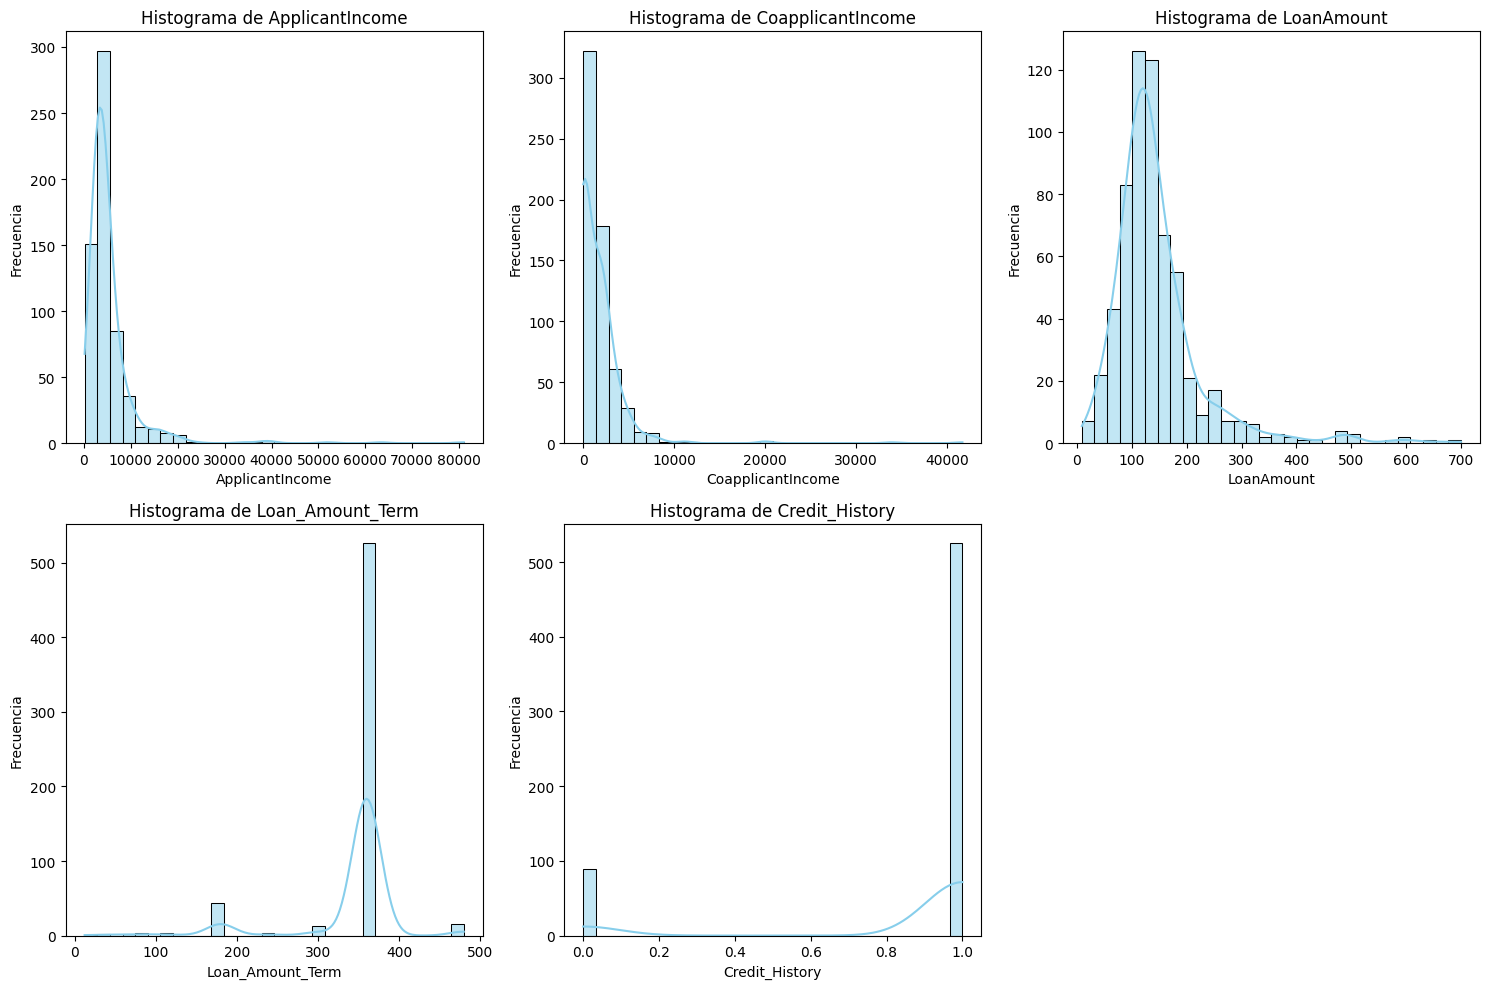

In [15]:
plt.figure(figsize=(15, 10)) # crearmos el grafico con dimension 15,10

for i, col in enumerate(numerical_columns, 1): # iteramos para mostrar los graficos para cada columna categorica
    plt.subplot(2, 3, i)  # 2 filas y 3 columnas de gráficos
    sns.histplot(df[col], bins=30, kde=True, color='skyblue', edgecolor='black')
    plt.title(f'Histograma de {col}') # titulo para cada gragico
    plt.xlabel(col) # etiqueta para el eje x
    plt.ylabel('Frecuencia') # etiqueta para el eje y

plt.tight_layout() # distribucion 
plt.show() # muestra el grafico

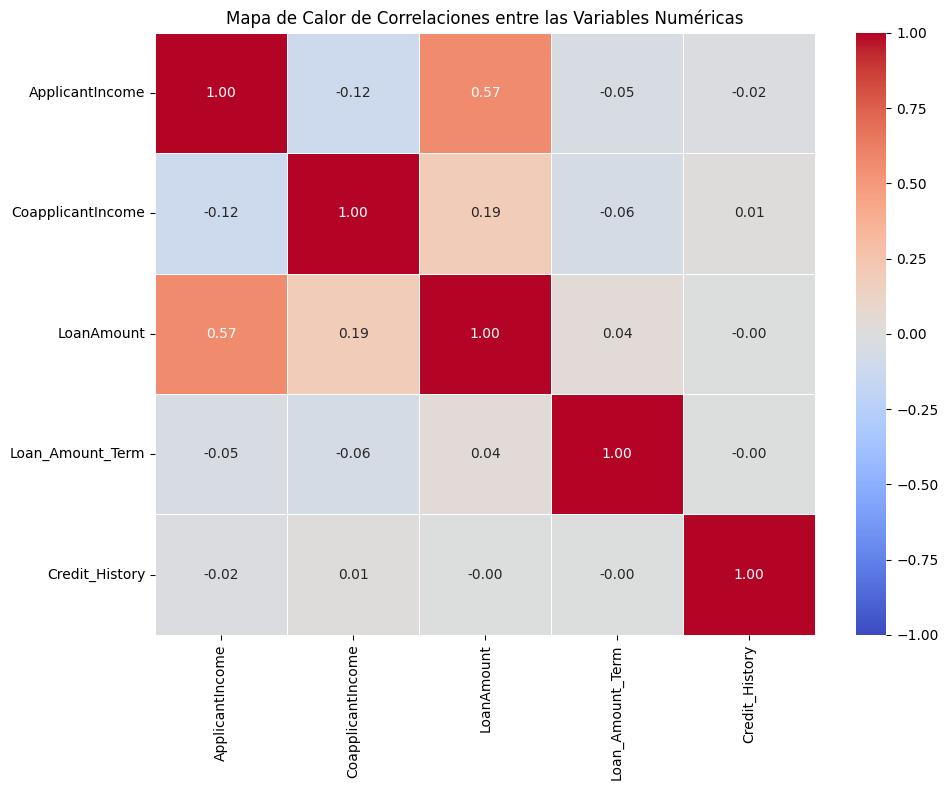

In [12]:


# Calcular la matriz de correlación solo para columnas numéricas
correlation_matrix = numerical_columns.corr()

# Crear el mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)

# Añadir título
plt.title('Mapa de Calor de Correlaciones entre las Variables Numéricas')

# Mostrar el mapa de calor
plt.tight_layout()
plt.show()

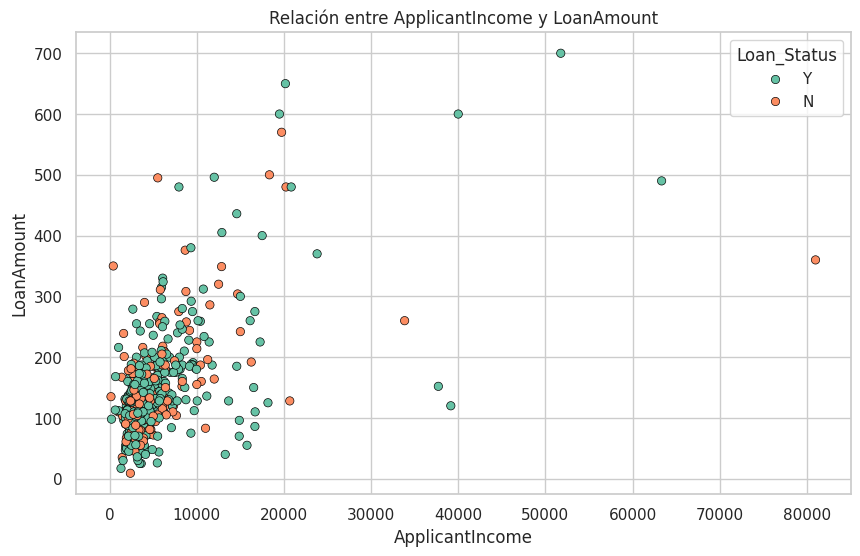

In [17]:
# establecemos el estilo de los gráficos
sns.set(style="whitegrid")
# creamos un gráfico de dispersión entre dos variables numéricas
plt.figure(figsize=(10, 6))
# Relación entre ApplicantIncome y LoanAmount
sns.scatterplot(data=df, x='ApplicantIncome', y='LoanAmount', hue='Loan_Status', palette='Set2', edgecolor='black')
# Títulos y etiquetas
plt.title('Relación entre ApplicantIncome y LoanAmount') # titulo del grafico
plt.xlabel('ApplicantIncome') # etiqueta para el eje x
plt.ylabel('LoanAmount') # etiqueta para el eje y
plt.show() # mostramos el grafico

## 3. Valores Faltantes y Outliers:
* Detectar y tratar valores faltantes.
* Identificar y manejar outliers.

In [18]:
df.isnull().sum() # verificamos si existen valores nulos

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [19]:
# Calcular Q1 (percentil 25) y Q3 (percentil 75)
Q1 = df['LoanAmount'].quantile(0.25)
Q3 = df['LoanAmount'].quantile(0.75)
# Calcular el rango intercuartílico (IQR)
IQR = Q3 - Q1
# Definir los límites superior e inferior
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# Detectar outliers
outliers = df[(df['LoanAmount'] < lower_bound) | (df['LoanAmount'] > upper_bound)]
# Mostrar los outliers
print(outliers)


      Loan_ID  Gender Married Dependents     Education Self_Employed  \
5    LP001011    Male     Yes          2      Graduate           Yes   
9    LP001020    Male     Yes          1      Graduate            No   
21   LP001046    Male     Yes          1      Graduate            No   
34   LP001100    Male      No         3+      Graduate            No   
54   LP001186  Female     Yes          1      Graduate           Yes   
67   LP001233    Male     Yes          1      Graduate            No   
83   LP001273    Male     Yes          0      Graduate            No   
126  LP001448    Male     Yes         3+      Graduate            No   
130  LP001469    Male      No          0      Graduate           Yes   
135  LP001488    Male     Yes         3+      Graduate            No   
155  LP001536    Male     Yes         3+      Graduate            No   
161  LP001562    Male     Yes          0      Graduate            No   
171  LP001585    Male     Yes         3+      Graduate          

In [20]:
# Calcular la media y la desviación estándar
mean = df['LoanAmount'].mean()
std_dev = df['LoanAmount'].std()
# Detectar outliers utilizando la desviación estándar (más de 3 desviaciones estándar)
outliers_std = df[(df['LoanAmount'] > mean + 3 * std_dev) | (df['LoanAmount'] < mean - 3 * std_dev)]
# Mostrar los outliers detectados por desviación estándar
print(outliers_std)

      Loan_ID  Gender Married Dependents Education Self_Employed  \
130  LP001469    Male      No          0  Graduate           Yes   
155  LP001536    Male     Yes         3+  Graduate            No   
171  LP001585    Male     Yes         3+  Graduate            No   
177  LP001610    Male     Yes         3+  Graduate            No   
278  LP001907    Male     Yes          0  Graduate            No   
308  LP001996    Male      No          0  Graduate            No   
333  LP002101    Male     Yes          0  Graduate            No   
369  LP002191    Male     Yes          0  Graduate            No   
432  LP002386    Male      No          0  Graduate            No   
487  LP002547    Male     Yes          1  Graduate            No   
506  LP002624    Male     Yes          0  Graduate            No   
523  LP002693    Male     Yes          2  Graduate           Yes   
525  LP002699    Male     Yes          2  Graduate           Yes   
561  LP002813  Female     Yes          1  Gradua

# Parte 3: Preprocesamiento de Datos

## 1. Transformación de Columnas:
* Codificar variables categóricas utilizando One-Hot Encoding.
* Escalar características numéricas utilizando StandardScaler.

In [21]:
# Codificación de variables categóricas usando One-Hot Encoding
df_encoded = pd.get_dummies(df, drop_first=True)
# Mostrar las primeras filas del DataFrame codificado
print(df_encoded.head())

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             5849                0.0       128.0             360.0   
1             4583             1508.0       128.0             360.0   
2             3000                0.0        66.0             360.0   
3             2583             2358.0       120.0             360.0   
4             6000                0.0       141.0             360.0   

   Credit_History  Loan_ID_LP001003  Loan_ID_LP001005  Loan_ID_LP001006  \
0             1.0             False             False             False   
1             1.0              True             False             False   
2             1.0             False              True             False   
3             1.0             False             False              True   
4             1.0             False             False             False   

   Loan_ID_LP001008  Loan_ID_LP001011  ...  Gender_Male  Married_Yes  \
0             False             False  ...        

In [24]:
# Seleccionar las columnas numéricas para escalar
numerical_columns = df_encoded.select_dtypes(include=['float64', 'int64']).columns
# Crear el escalador
scaler = StandardScaler()
# Escalar las características numéricas
df_encoded[numerical_columns] = scaler.fit_transform(df_encoded[numerical_columns])
# Mostrar las primeras filas del DataFrame escalado
print(df_encoded.head())

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0         0.072991          -0.554487   -0.211241          0.273231   
1        -0.134412          -0.038732   -0.211241          0.273231   
2        -0.393747          -0.554487   -0.948996          0.273231   
3        -0.462062           0.251980   -0.306435          0.273231   
4         0.097728          -0.554487   -0.056551          0.273231   

   Credit_History  Loan_ID_LP001003  Loan_ID_LP001005  Loan_ID_LP001006  \
0        0.411733             False             False             False   
1        0.411733              True             False             False   
2        0.411733             False              True             False   
3        0.411733             False             False              True   
4        0.411733             False             False             False   

   Loan_ID_LP001008  Loan_ID_LP001011  ...  Gender_Male  Married_Yes  \
0             False             False  ...        

## 2. División del Conjunto de Datos:
* Dividir el dataset en conjuntos de entrenamiento y prueba.

In [25]:
# Definir las características (X) y el target (y)
X = df_encoded.drop('Loan_Status_Y', axis=1)  # Eliminar la columna 'Loan_Status_Y' de las características
y = df_encoded['Loan_Status_Y']  # Usar 'Loan_Status_Y' como el target
# Dividir el dataset en entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
# Mostrar las formas de los conjuntos de entrenamiento y prueba
print(f"Conjunto de entrenamiento (X_train): {X_train.shape}")
print(f"Conjunto de prueba (X_test): {X_test.shape}")

Conjunto de entrenamiento (X_train): (491, 627)
Conjunto de prueba (X_test): (123, 627)


# Parte 4: Implementación de LightGBM (LGBM)

## 1. Entrenamiento del Modelo:
* Entrenar un modelo de LGBM con hiperparámetros básicos.
* Evaluar el modelo utilizando métricas de rendimiento como la exactitud, precisión, recall, F1-Score y ROC-AUC.

In [27]:
# Crear un dataset de LightGBM
train_data = lgb.Dataset(X_train, label=y_train)

# Configuración de los hiperparámetros básicos de LightGBM
params = {
    'objective': 'binary', # Problema de clasificación binaria
    'metric': 'binary_error', # Métrica para clasificación binaria
    'boosting_type': 'gbdt', # Tipo de boosting (Gradient Boosting Decision Tree)
    'num_leaves': 31, # Número de hojas en cada árbol
    'learning_rate': 0.05, # Tasa de aprendizaje
    'feature_fraction': 0.9, # Fracción de características a usar en cada iteración
    'bagging_fraction': 0.8, # Fracción de datos a usar en cada iteración
    'bagging_freq': 5, # Frecuencia de re-muestreo de datos
    'verbose': -1 # Nivel de verbosidad (-1 para suprimir)
}

# Entrenamiento del modelo
model = lgb.train(params, train_data, num_boost_round=100)
# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)
y_pred_binary = (y_pred >= 0.5).astype(int)  # Convertir probabilidades a etiquetas binarias
# Evaluar el rendimiento del modelo
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.7805


In [22]:

accuracy = accuracy_score(y_test, y_pred_binary) # Exactitud (Accuracy)
precision = precision_score(y_test, y_pred_binary) # Precisión (Precision)
recall = recall_score(y_test, y_pred_binary) # 
f1 = f1_score(y_test, y_pred_binary) # puntuacion F1
roc_auc = roc_auc_score(y_test, y_pred) # ROC-AUC


In [23]:
# Mostrar las métricas
print(f"Exactitud (Accuracy): {accuracy:.4f}")
print(f"Precisión (Precision): {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

Exactitud (Accuracy): 0.7805
Precisión (Precision): 0.7624
Recall: 0.9625
F1-Score: 0.8508
ROC-AUC: 0.7317


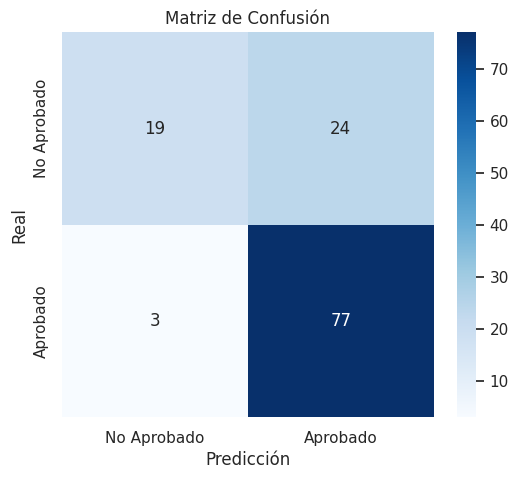

In [24]:
# 3. Matriz de confusión
cm = confusion_matrix(y_test, y_pred_binary)

# Visualizar la matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Aprobado', 'Aprobado'], yticklabels=['No Aprobado', 'Aprobado'])
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

## 2. Optimización de Hiperparámetros:
* Utilizar GridSearchCV para optimizar los hiperparámetros del modelo de LGBM.

In [25]:
# Crear el modelo LGBM con parámetros base
lgbm_model = lgb.LGBMClassifier(objective='binary', metric='binary_error', random_state=42)

# Definir el espacio de parámetros a explorar
param_grid = {
    'num_leaves': [31, 50],            # Reducido en lugar de 31, 50, 100
    'learning_rate': [0.05, 0.1],      # Reducido en lugar de 0.01, 0.05, 0.1
    'n_estimators': [50, 100],         # Reducido en lugar de 50, 100, 200
    'max_depth': [5, 10],               # Ajuste limitado
    'subsample': [0.8, 1.0],            # Ajuste limitado
    'colsample_bytree': [0.8, 1.0]      # Ajuste limitado
}

# Crear el objeto GridSearchCV
grid_search = GridSearchCV(estimator=lgbm_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Ajustar GridSearchCV al conjunto de entrenamiento
grid_search.fit(X_train, y_train)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 274, number of negative: 119
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 393, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.697201 -> initscore=0.834005
[LightGBM] [Info] Start training from score 0.834005
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

GridSearchCV(cv=5,
             estimator=LGBMClassifier(metric='binary_error', objective='binary',
                                      random_state=42),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.05, 0.1], 'max_depth': [5, 10],
                         'n_estimators': [50, 100], 'num_leaves': [31, 50],
                         'subsample': [0.8, 1.0]},
             scoring='accuracy')

In [26]:
# Mostrar los mejores parámetros encontrados
print("Mejores parámetros encontrados: ", grid_search.best_params_)

# Realizar predicciones con el mejor modelo
y_pred = grid_search.best_estimator_.predict(X_test)

# Evaluar el rendimiento del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Exactitud del modelo optimizado: {accuracy:.4f}")

Mejores parámetros encontrados:  {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 50, 'num_leaves': 31, 'subsample': 0.8}
Exactitud del modelo optimizado: 0.7886


## 3. Evaluación del Modelo Optimizado:
* Evaluar el rendimiento del modelo optimizado y compararlo con el modelo inicial.

In [27]:
# 1. Entrenar el modelo inicial (sin optimización de hiperparámetros)
initial_model = lgb.LGBMClassifier(random_state=42)
initial_model.fit(X_train, y_train)

# 2. Evaluar el modelo inicial
y_pred_initial = initial_model.predict(X_test)
y_pred_initial_prob = initial_model.predict_proba(X_test)[:, 1]

# Calcular métricas de rendimiento
accuracy_initial = accuracy_score(y_test, y_pred_initial)
precision_initial = precision_score(y_test, y_pred_initial)
recall_initial = recall_score(y_test, y_pred_initial)
f1_initial = f1_score(y_test, y_pred_initial)
roc_auc_initial = roc_auc_score(y_test, y_pred_initial_prob)

In [31]:
# 3. Optimizar el modelo usando GridSearchCV (como ejemplo)
param_dist = {
    'num_leaves': [31, 50, 100, 150],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [-1, 5, 10, 15],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Crear el modelo base de LGBM
lgbm_model = lgb.LGBMClassifier(random_state=42)

# Crear el objeto GridSearchCV
grid_search = GridSearchCV(estimator=lgbm_model, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)

# Ajustar el GridSearchCV al conjunto de entrenamiento
start_time = time.time()
grid_search.fit(X_train, y_train)
end_time = time.time()

# Mostrar los mejores parámetros encontrados
print("\nMejores parámetros encontrados por GridSearchCV:", grid_search.best_params_)
print(f"Tiempo de búsqueda en GridSearchCV: {end_time - start_time:.2f} segundos")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 228, number of negative: 99
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 228, number of negative: 100
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 228, number of negative: 99[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines

[LightGBM] [Info] Number of positive: 228, number of negative: 99
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046412 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 271
[LightGBM] [Info] Number of data points in the train set: 327, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.697248 -> inits

/home/cvelazquez/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



Mejores parámetros encontrados por GridSearchCV: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 50, 'num_leaves': 31, 'subsample': 0.8}
Tiempo de búsqueda en GridSearchCV: 37.16 segundos


In [29]:
# Mostrar los resultados del modelo inicial
print("Modelo Inicial (Sin Optimización de Hiperparámetros):")
print(f"Exactitud: {accuracy_initial:.4f}")
print(f"Precisión: {precision_initial:.4f}")
print(f"Recall: {recall_initial:.4f}")
print(f"F1-Score: {f1_initial:.4f}")
print(f"ROC-AUC: {roc_auc_initial:.4f}")

Modelo Inicial (Sin Optimización de Hiperparámetros):
Exactitud: 0.7642
Precisión: 0.7629
Recall: 0.9250
F1-Score: 0.8362
ROC-AUC: 0.7404


In [30]:
# 4. Evaluar el modelo optimizado
y_pred_optimized = grid_search.best_estimator_.predict(X_test)
y_pred_optimized_prob = grid_search.best_estimator_.predict_proba(X_test)[:, 1]

# Calcular métricas de rendimiento
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
precision_optimized = precision_score(y_test, y_pred_optimized)
recall_optimized = recall_score(y_test, y_pred_optimized)
f1_optimized = f1_score(y_test, y_pred_optimized)
roc_auc_optimized = roc_auc_score(y_test, y_pred_optimized_prob)

# Mostrar los resultados del modelo optimizado
print("\nModelo Optimizado (con GridSearchCV):")
print(f"Exactitud: {accuracy_optimized:.4f}")
print(f"Precisión: {precision_optimized:.4f}")
print(f"Recall: {recall_optimized:.4f}")
print(f"F1-Score: {f1_optimized:.4f}")
print(f"ROC-AUC: {roc_auc_optimized:.4f}")

# 5. Comparar el rendimiento de ambos modelos
print("\nComparación del rendimiento de los modelos:")
print(f"Mejora en Exactitud: {accuracy_optimized - accuracy_initial:.4f}")
print(f"Mejora en Precisión: {precision_optimized - precision_initial:.4f}")
print(f"Mejora en Recall: {recall_optimized - recall_initial:.4f}")
print(f"Mejora en F1-Score: {f1_optimized - f1_initial:.4f}")
print(f"Mejora en ROC-AUC: {roc_auc_optimized - roc_auc_initial:.4f}")


Modelo Optimizado (con GridSearchCV):
Exactitud: 0.7886
Precisión: 0.7596
Recall: 0.9875
F1-Score: 0.8587
ROC-AUC: 0.6937

Comparación del rendimiento de los modelos:
Mejora en Exactitud: 0.0244
Mejora en Precisión: -0.0033
Mejora en Recall: 0.0625
Mejora en F1-Score: 0.0225
Mejora en ROC-AUC: -0.0467
